# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [3]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [65]:
# Add any additional import statements you need here
import requests
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/fkrasovsky/OneDrive - Allvue Systems/Documents/usd/msads-509/Module-1-Scraping-APIs-and Research Questions/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




#### Lyrics Data Ingestion

In [8]:
# Read in the lyrics data

# point at the folder containing lyrics for all our artists
lyrics_path = data_location+'/'+lyrics_folder
artists = os.listdir(lyrics_path)

#iterate over both artists, get a list of all the text files containing their songs, read them into separate dataframes.
#we can create dynamic variable names for the dfs using the globals function.

song_artist = []
song_names = []
song_lyrics = []

for artist in artists:
    
    artist_path = lyrics_path + artist
    songs = os.listdir(artist_path)

    # get each song for our artist, read it in as a string, and append it to a list.
    for song in songs:
        song_path = artist_path + '/' + song
        
        with open(song_path) as f:
            lines = f.readlines()

        # we also need a meaningful way to extract the song name. the rule for 
        # this dataset is that the title is separated by at least one carriage return,
        # and we also know that it's always on the first line.
        
        this_song = lines[0]
        this_lyrics = ' '.join(lines[1:])
        
        song_artist.append(artist)
        song_names.append(this_song)
        song_lyrics.append(this_lyrics)

d = {
        'artist':song_artist,
        'song_name': song_names,
        'text': song_lyrics
    }

#turn into a datafreame and do a sanity check
df = pd.DataFrame(d)
df.head()

,artist,song_name,text
0,smash mouth,105\n,\n \n \n \n Why the hell are we waitin' in lin...
1,smash mouth,2000 Miles\n,\n \n \n \n He's gone 2000 miles\n It's very f...
2,smash mouth,All Star\n,\n \n \n \n Somebody once told me the world is...
3,smash mouth,Always Gets Her Way\n,\n \n \n \n I know she likes her magazines\n \...
4,smash mouth,Beautiful Bomb\n,\n \n \n \n Your asteroids bounce off her like...


#### Twitter Data Ingestion

In [9]:
# Read in the twitter data
#read in the twitter data
twitter_path = data_location+'/'+twitter_folder
descriptions = []

for file in os.listdir(twitter_path):
    if (file.split('.')[1]=='tsv'):
        
        artist_name = file.split('_')[0]
        follower_data = pd.read_csv(twitter_path+'/'+file,sep='\t')
        follower_data['artist'] = artist_name
        follower_desc = follower_data[['description','artist']]
        descriptions.append(follower_desc)
        
twitter_df = pd.DataFrame(descriptions[0].append(descriptions[1], 
                  ignore_index = True),columns=['description','artist'])
twitter_df = twitter_df.rename(columns={"description": "text"})
twitter_df.head()

,text,artist
0,I'm whatever SHHS'21 Not on Twitter much..,smashmouth
1,NaN,smashmouth
2,17 | i game occasionally | matching with @batb...,smashmouth
3,22 He/Him Spotted Hyena British Autistic I lik...,smashmouth
4,26 • Guy who games • BotW glitch enthusiast • ...,smashmouth


In [42]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sentiment = {}

#we know that the first 34 lines are metadata, so we skip them.

with open(positive_words_file) as file:
    words = file.readlines()[35:]
    
    #remove newline characters
    for i in range(0,len(words)):
        words[i] = words[i].strip("\n")
        sentiment[words[i]] = 1 
        
with open(negative_words_file) as file:
    words = file.readlines()[35:]
    
    #remove newline characters
    for i in range(0,len(words)):
        words[i] = words[i].strip("\n")
        sentiment[words[i]] = -1 
        
# dealing with the tidytext sentiments is unique because of its dataframe structure.
def sentiment_convert(sentiment):
    if sentiment=="positive":
        return 1
    return -1
# convert sentiment into 1 and -1
tidy = pd.read_csv(tidy_text_file,sep="\t")
tidy['num_sentiment'] = tidy['sentiment'].map(sentiment_convert)

# update the sentiment dictionary with the tidy words.
tidy_dict = dict(zip(tidy['word'], tidy['num_sentiment']))
sentiment.update(tidy_dict)

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [49]:
#create a function that scores the sentiment for a body of text by dividing the sum of sentiment points by
#the total number of words.
def score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in sentiment:
            sentiment_score += sentiment[word]
            
    return sentiment_score / len(bag_of_words)

df['sentiment_score'] = df['text'].map(score)
df.head()

,artist,song_name,text,sentment_score,sentiment_score
0,smash mouth,105\n,\n \n \n \n Why the hell are we waitin' in lin...,0.008929,0.008929
1,smash mouth,2000 Miles\n,\n \n \n \n He's gone 2000 miles\n It's very f...,0.008547,0.008547
2,smash mouth,All Star\n,\n \n \n \n Somebody once told me the world is...,0.028736,0.028736
3,smash mouth,Always Gets Her Way\n,\n \n \n \n I know she likes her magazines\n \...,0.071006,0.071006
4,smash mouth,Beautiful Bomb\n,\n \n \n \n Your asteroids bounce off her like...,-0.008197,-0.008197


#### Insight 1: Average sentiment per song by artist

In [50]:
df.groupby("artist")['sentiment_score'].mean()

artist
smash mouth    0.017300
wallows        0.011347
Name: sentiment_score, dtype: float64

#### Insight 2: Highest and Lowest Sentiments for Smash Mouth
we could have probably just run this code twice, but let's do a function anyway!

In [58]:
def highLowSongs(df,artist):
    
    sm_max = df.query(f"artist=='{artist}'")['sentiment_score'].idxmax()
    sm_max_song = df.iloc[sm_max]['song_name'].strip("\n")
    sm_max_score = df.iloc[sm_max]['sentiment_score']
    
    sm_min = df.query(f"artist=='{artist}'")['sentiment_score'].idxmin()
    sm_min_song = df.iloc[sm_min]['song_name'].strip("\n")
    sm_min_score = df.iloc[sm_min]['sentiment_score']
    
    print(f"The highest-sentiment song for {artist} is: {sm_max_song} with a score of {sm_max_score}")
    print(f"The lowest-sentiment song for {artist} is: {sm_min_song} with a score of {sm_min_score}")
    
highLowSongs(df,'smash mouth')

The highest-sentiment song for smash mouth is: Can't Get Enough Of You Baby with a score of 0.1828793774319066
The lowest-sentiment song for smash mouth is: Sorry About Your Penis with a score of -0.07991803278688525


#### Insight 3: Highest and Lowest Sentiments for Wallows

In [60]:
highLowSongs(df,'wallows')

The highest-sentiment song for wallows is: Let The Sun In with a score of 0.10894941634241245
The lowest-sentiment song for wallows is: Do Not Wait with a score of -0.06964285714285715


### Questions

**Q: Overall, which artist has the higher average sentiment per song?**

A: Smash Mouth has a slightly higher sentiment score, on average, compared to Wallows, which is in line with subject matter expertise that the Wallows write music for people that are too shy to say hello to their crush at a house party.

---

**Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.**

A: For smash mouth, Can't get enough of you baby has the highest sentiment, while the lowest-ranking song is Sorry About Your Penis.

---

**Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.**

For the Wallows, Let the Sun In has the highest sentiment while Do Not Wait has the lowest sentiment.

---

**Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.**




#### Histogram for Smash Mouth

<AxesSubplot:ylabel='Frequency'>

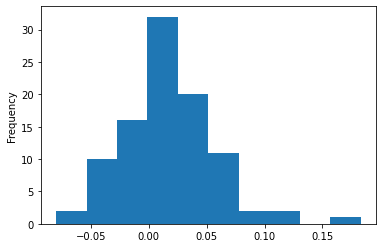

In [62]:
df.query("artist=='smash mouth'")['sentiment_score'].plot(kind='hist')

#### Histogram for Wallows

<AxesSubplot:ylabel='Frequency'>

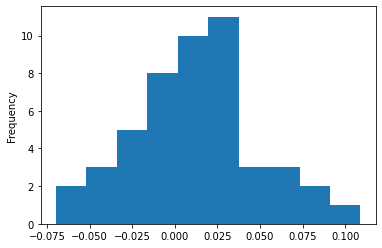

In [63]:
df.query("artist=='wallows'")['sentiment_score'].plot(kind='hist')

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

#### Step 1: Scrape a library of emojis and sentiment scores
for this, we can use a small lexicon created by <a href='http://kt.ijs.si/data/Emoji_sentiment_ranking/'>Novak, et al</a> and parse the webpage for a handy list of 80 emojis and round up their sentiment scores to 1 or -1. We use BS to go through each row and identify the emoji and the score.

In [94]:
emojis = requests.get('http://kt.ijs.si/data/Emoji_sentiment_ranking/')
soup = BeautifulSoup(emojis.text,'html.parser')
emoji_data = soup.find_all("tr")
print(emoji_data[0:1])

[<tr class="tableizer-firstrow">
<th>Char</th><th>Image<br/>[twemoji]</th><th>Unicode<br/>codepoint</th><th>Occurrences<br/>[5...max]</th><th>Position<br/>[0...1]</th><th>Neg<br/>[0...1]</th><th>Neut<br/>[0...1]</th><th>Pos<br/>[0...1]</th><th>Sentiment score<br/>[-1...+1]</th><th>Sentiment bar<br/>(c.i. 95%)</th><th>Unicode name</th><th>Unicode block</th></tr>]


In [101]:
emoji_lexicon = {}

#iterate over our BS object and extract the icon and sentiment score for each emoji.
#coerce the sentiment to 1 or -1.
for emoji in emoji_data[1:]:
    these_columns = emoji.find_all("td")
    this_icon = these_columns[0].text
    this_sentiment = float(these_columns[8].text)
    
    if (this_sentiment >= 0):
        this_sentiment = 1 
    else:
        this_sentiment = -1
    
    emoji_lexicon[this_icon] = this_sentiment
    
#print a small sample of our work as a sanity check 
str(emoji_lexicon)[0:32]

"{'😂': 1, '❤': 1, '♥': 1, '😍': 1,"

#### Step 2: Score our Twitter Data with the emoji Lexicon

In [ ]:
def emoji_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in emoji_lexicon:
            sentiment_score += emoji_lexicon[word]
            
    return sentiment_score / len(bag_of_words)

#coerce text to str first to handle float edge cases.
twitter_df['text'] = twitter_df['text'].astype(str)
twitter_df['emoji_sentiment'] = twitter_df['text'].map(emoji_score)

In [105]:
#let's see how we did!
twitter_df.sort_values('emoji_sentiment',ascending=False).head()

,text,artist,emoji_sentiment
71416,🎠 🌝 🎠,wallowsmusic,1.0
98405,💕,wallowsmusic,1.0
117592,🌆,wallowsmusic,1.0
90535,🐾,wallowsmusic,1.0
107499,🏡,wallowsmusic,1.0


#### Step 3. Get average score by artist

In [106]:
twitter_df.groupby("artist")['emoji_sentiment'].mean()

artist
smashmouth      0.008093
wallowsmusic    0.016267
Name: emoji_sentiment, dtype: float64

#### Step 4. Get most common positive emoji by artist
for this part, we employ a strategy of cloning a dictionary with only the positive emojis and cycling through our twitter_df, creating a list of emojis for each data point, merging the lists together, and creating a counter. 

In [112]:
positive_emojis = {}
for k,v in emoji_lexicon.items():
    if v == 1:
        positive_emojis[k] = v

In [ ]:
def get_positive_emojis(text):
    return [t for t in word_tokenize(text.lower()) if t in positive_emojis]

def combine_tokens(tokens):
    out = []
    for token_list in tokens:
        out = out + token_list
    return out

#place all the emojis for each bio into a list 
twitter_df['pos_emojis'] = twitter_df['text'].map(get_positive_emojis)

In [ ]:
#get a list of emojis for each artist. notice the second expression where we reaffirm
#that there are only two types of bands - smash mouth, and not smash mouth.
smashmouth = combine_tokens(twitter_df.query("artist=='smashmouth'")['pos_emojis'])
wallows = combine_tokens(twitter_df.query("artist!='smashmouth'")['pos_emojis'])

Q: What is the average sentiment of your two artists? 

A: Smashmouth has an average score of .008 while wallows has an average score of 0.016.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: See below:



In [119]:
print(Counter(smashmouth).most_common(1))

[('✨', 294)]


the most common emoji in a twitter bio for a smash mouth fan is very appropriate, since most of them personally identify as an all-star.

In [121]:
print(Counter(wallows).most_common(2))

[('⠀', 932), ('♡', 626)]


Wallows followers tend to use white hearts the most often out of all positive emojis.